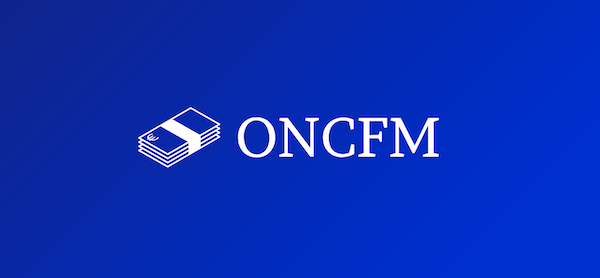

<font color="lightblue">Objectif : mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets. Et ce à partir de certaines dimensions du billet et des éléments qui le composent.</font>

<font color="deepskyblue">

<strong>Summary</strong>
1. EDA
   1. Import des bibliothèques
   2. Import et lecture du jeu de données
   3. Exploration et dimension des données
   4. Analyse univariée
   5. Analyse bivariée
   6. Exploration des valeurs manquantes
2. Inférer les valeurs manquantes via une Régression Linéaire
   1. Scinder le jeu de données en deux
   2. Visualiser la relation linéaire
   3. Régression linéaire simple
   4. Régression linéaire multiple sans la variable "diagonale"
   5. Régression linéaire multiple complète
3. Performance de notre modèle
   1. Analyse des résidus
4. Complétude de notre dataframe avec les valeurs prédites par la régression linéaire

</font>

***************************************

### <font color='deepskyblue'> 1. EDA</font>

#### a) Import des bibliothèques

In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

# modèle de régression linéaire
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.model_selection import train_test_split

import scipy.stats as st
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import normal_ad, kstest_fit, het_breuschpagan, het_white

#### b) Import & lecture du dataset ONCFM

In [5]:
df = pd.read_csv("billets.csv", sep=";")
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


En résumé nous obtenons un dataset de :

    - 1500 échantillons
    - 7 colonnes

les variables suivantes:

    - 'is_genuine', => variable cible (type binaire : true or false)
    - 'diagonal', 
    - 'height_left', 
    - 'height_right', 
    - 'margin_low',
    - 'margin_up', 
    - 'length'

#### c) Exploration et dimensions

In [6]:
df.shape

(1500, 7)

In [7]:
df.columns

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


#### d) Analyse univariée

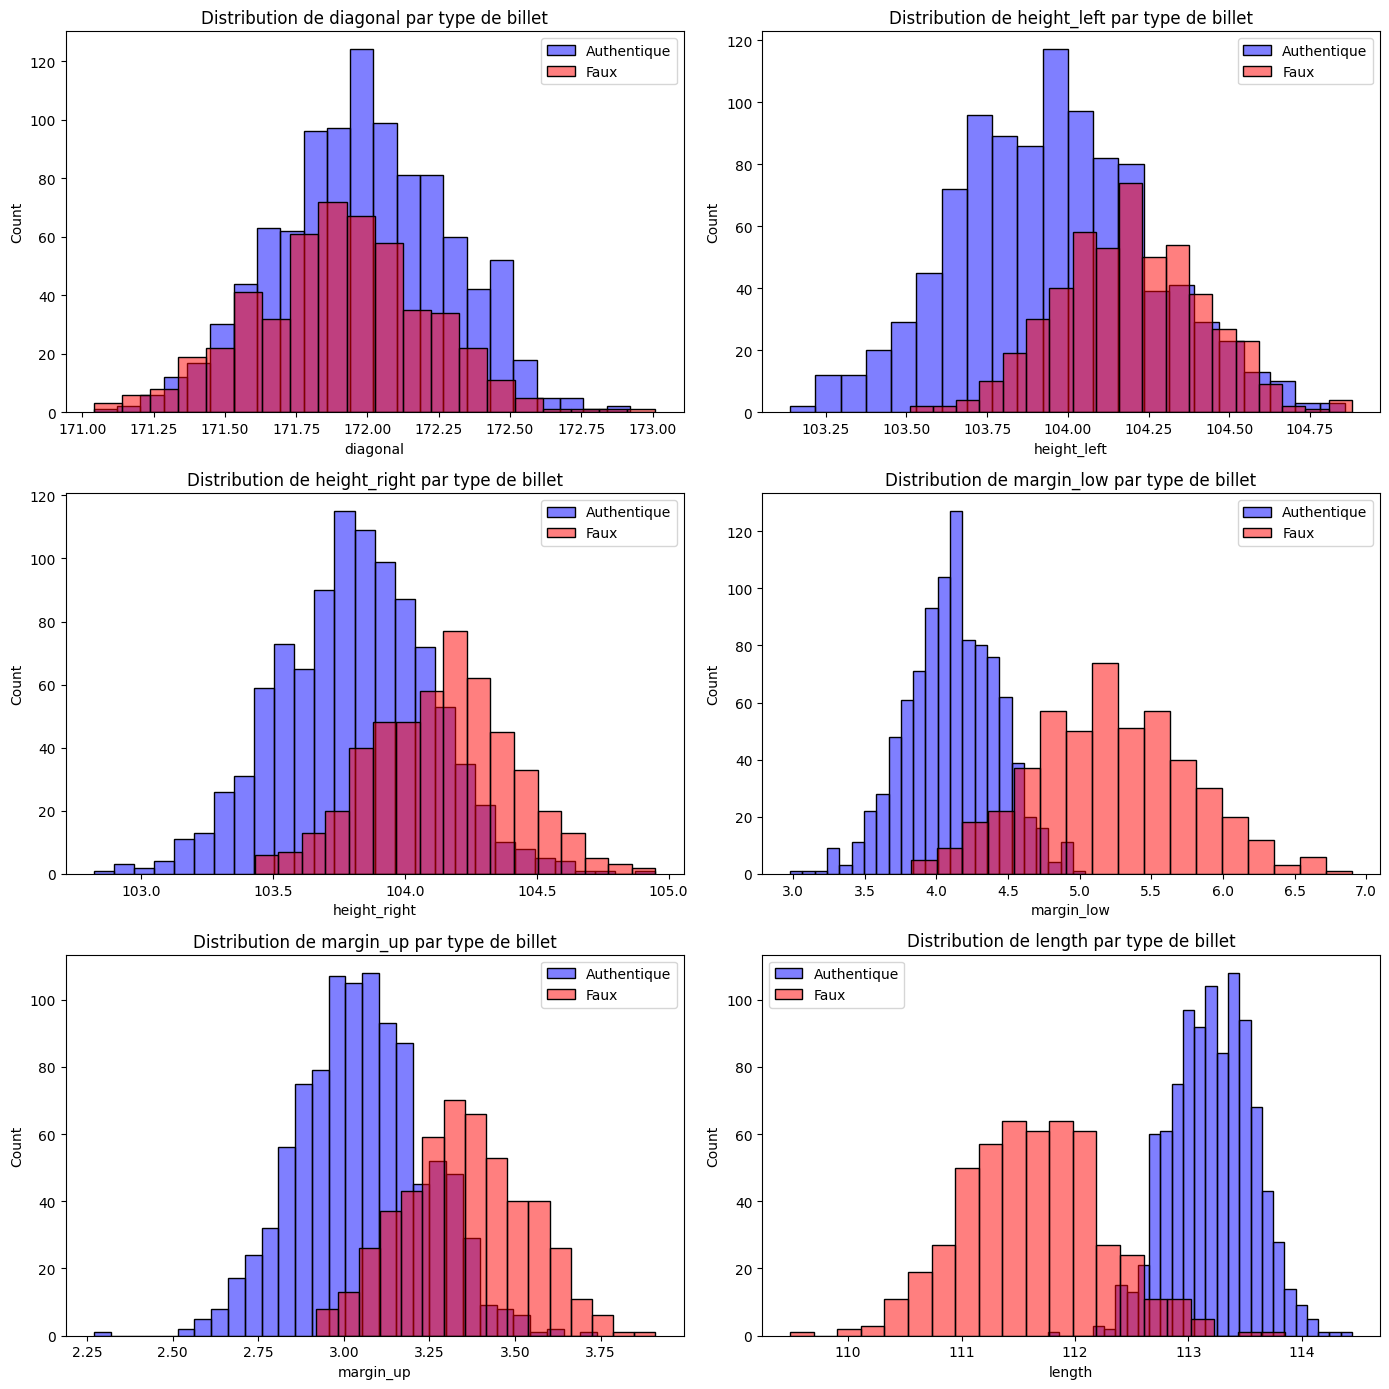

In [9]:
# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

# Tracer l'histogramme de chaque variable pour les vrais billets
for i, col in enumerate(df.columns[1:]):
    sns.histplot(data=df[df['is_genuine'] == True], x=col, ax=axes[i//2, i%2], color='blue', alpha=0.5, label='Authentique')
    sns.histplot(data=df[df['is_genuine'] == False], x=col, ax=axes[i//2, i%2], color='red', alpha=0.5, label='Faux')
    axes[i//2, i%2].set_title('Distribution de {} par type de billet'.format(col))
    axes[i//2, i%2].legend()

# Ajuster les paramètres de la disposition
plt.tight_layout()

# Afficher le graphique
plt.show()

- Transformez les variables pour faciliter l’apprentissage du modèle

In [10]:
df.is_genuine.value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

- Vrai billet => 1

- Faux billet => 0

In [11]:
df.loc[df.is_genuine == False, 'is_genuine'] = 0
df.loc[df.is_genuine == True, 'is_genuine'] = 1

In [12]:
df.is_genuine.value_counts()

is_genuine
1    1000
0     500
Name: count, dtype: int64

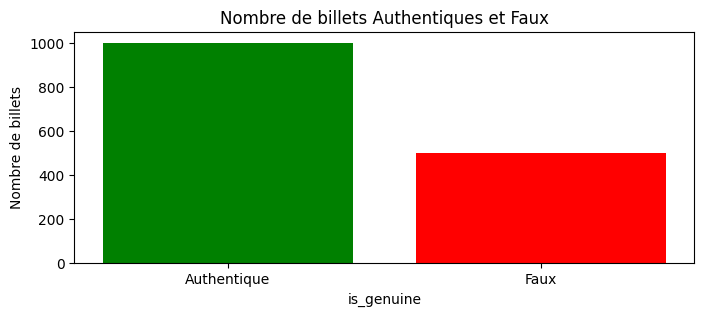

In [13]:
# Données
labels = ['Authentique', 'Faux']
counts = [1000, 500]

# Tracer le barplot
plt.figure(figsize=(8, 3))
plt.bar(labels, counts, color=['green', 'red'])
plt.title('Nombre de billets Authentiques et Faux')
plt.xlabel('is_genuine')
plt.ylabel('Nombre de billets')
plt.show()


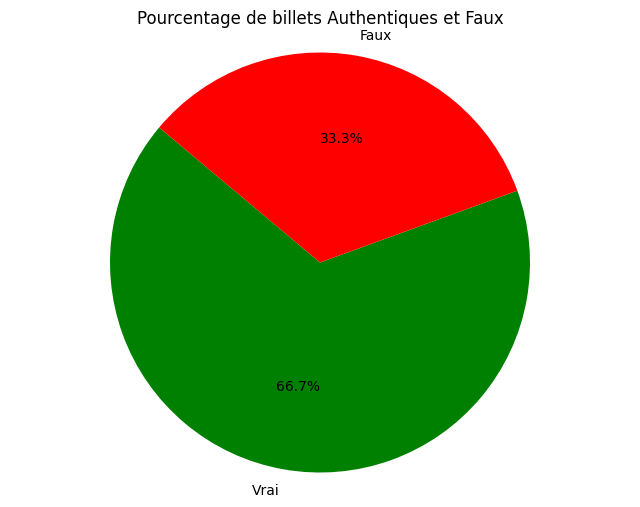

In [14]:
# Données
labels = ['Vrai', 'Faux']
counts = [1000, 500]

# Calculer les pourcentages
total = sum(counts)
percentages = [(count / total) * 100 for count in counts]

# Tracer le pie chart
plt.figure(figsize=(8, 6))
plt.pie(percentages, labels=labels, autopct='%1.1f%%', colors=['green', 'red'], startangle=140)
plt.title('Pourcentage de billets Authentiques et Faux')
plt.axis('equal')  # Assure un cercle parfait
plt.show()

<font color='lightgreen'>=> 29 valeurs manquantes dans les vrais billets et

=> 8 valeurs manquantes dans les faux billets

</font>

- statistiques descriptives

In [15]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


- Test de normalité des données

- Test de Shapiro-Wilk

In [16]:
from scipy.stats import shapiro

# Boucle sur chaque colonne du DataFrame
for col in df.columns:
    # Exclure les valeurs manquantes et la colonne 'is_genuine'
    if col != 'is_genuine':
        data = df[col].dropna()
        # Effectuer le test de Shapiro-Wilk
        stat, p_value = shapiro(data)
        # Interpréter les résultats du test
        if p_value < 0.05:
            print(f"Variable : {col} ne semble pas suivre une distribution normale (p-valeur = {p_value})")
        else:
            print(f"Variable : {col} semble suivre une distribution normale (p-valeur = {p_value})")


Variable : diagonal semble suivre une distribution normale (p-valeur = 0.32343590259552)
Variable : height_left semble suivre une distribution normale (p-valeur = 0.0509396530687809)
Variable : height_right semble suivre une distribution normale (p-valeur = 0.9806053638458252)
Variable : margin_low ne semble pas suivre une distribution normale (p-valeur = 2.8283876088209786e-24)
Variable : margin_up ne semble pas suivre une distribution normale (p-valeur = 0.000810406228993088)
Variable : length ne semble pas suivre une distribution normale (p-valeur = 7.863947037789753e-28)


#### e) Analyse bivarié

- Boxplot

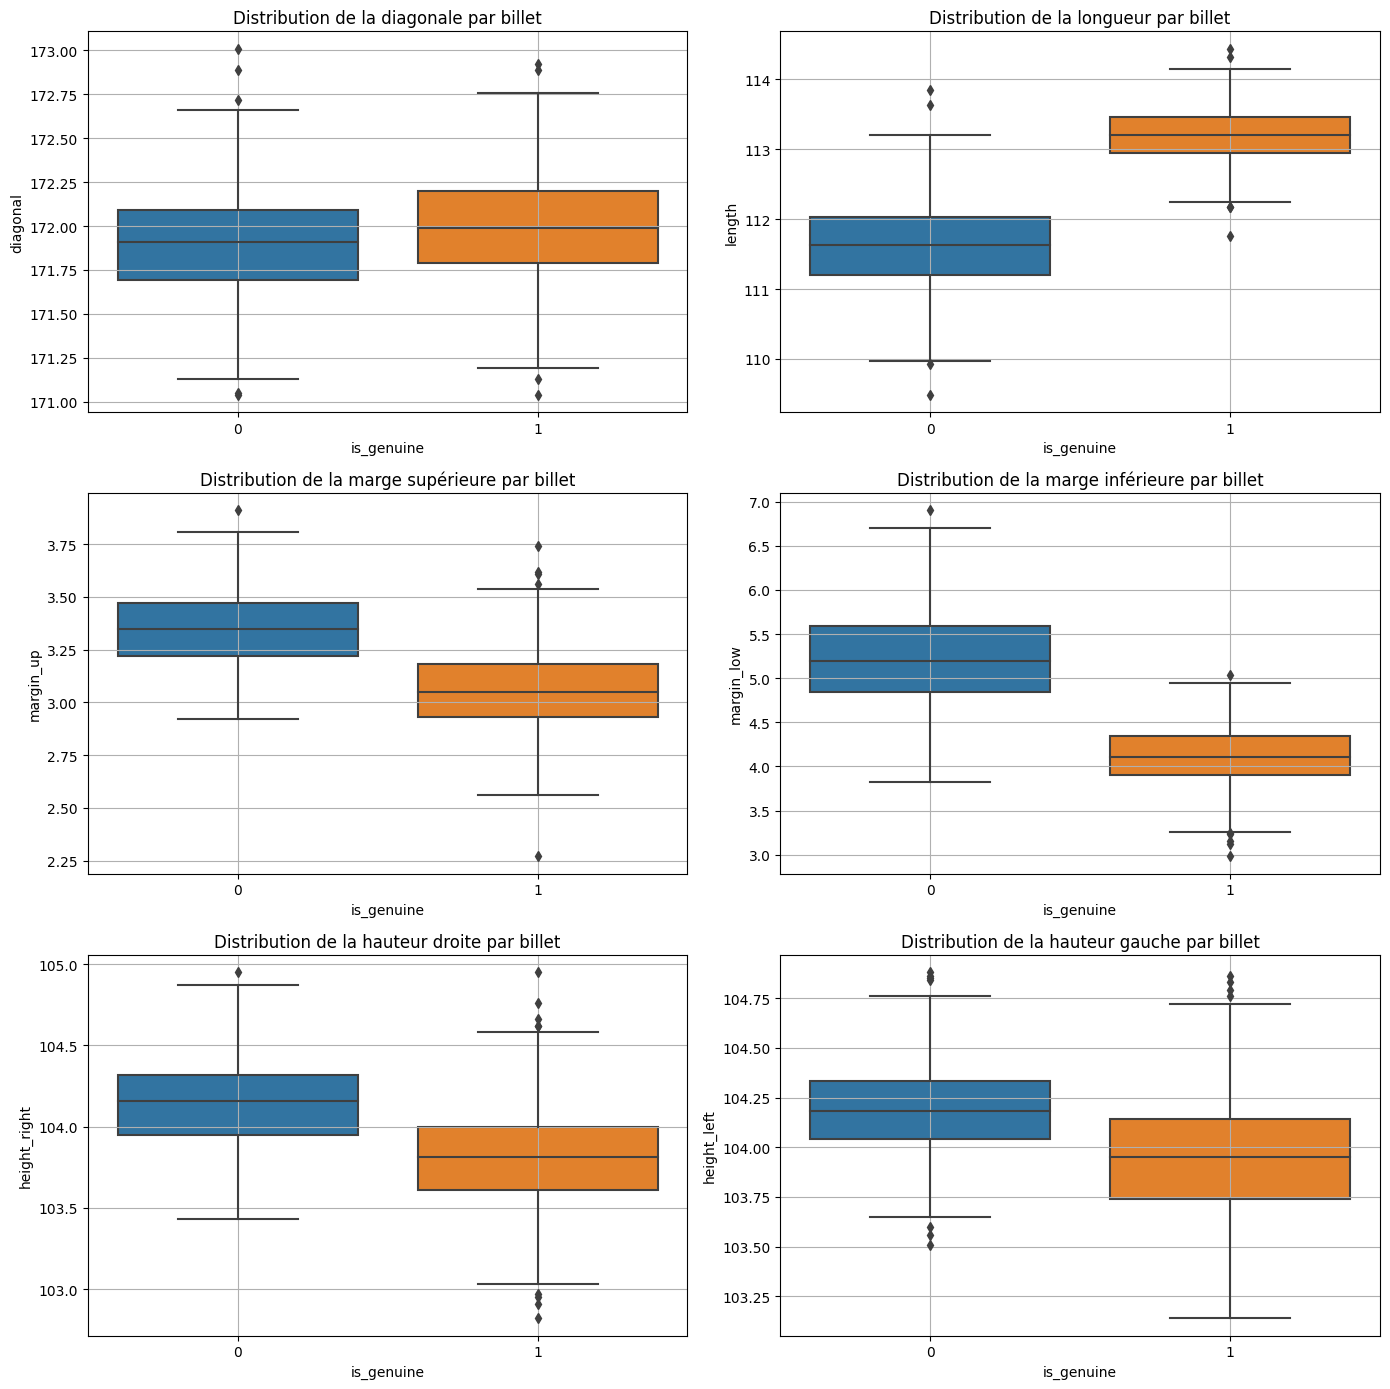

In [17]:
#df = df.reset_index("is_genuine")
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

sns.boxplot(data=df, y="diagonal", x="is_genuine", ax=axes[0, 0])
axes[0, 0].grid(True, which='both')
axes[0, 0].set_title('Distribution de la diagonale par billet')

sns.boxplot(data=df, y="length", x="is_genuine", ax=axes[0, 1])
axes[0, 1].grid(True, which='both')
axes[0, 1].set_title('Distribution de la longueur par billet')

sns.boxplot(data=df, y="margin_up", x="is_genuine", ax=axes[1, 0])
axes[1, 0].grid(True, which='both')
axes[1, 0].set_title('Distribution de la marge supérieure par billet')

sns.boxplot(data=df, y="margin_low", x="is_genuine", ax=axes[1, 1])
axes[1, 1].grid(True, which='both')
axes[1, 1].set_title('Distribution de la marge inférieure par billet')

sns.boxplot(data=df, y="height_right", x="is_genuine", ax=axes[2, 0])
axes[2, 0].grid(True, which='both')
axes[2, 0].set_title('Distribution de la hauteur droite par billet')

sns.boxplot(data=df, y="height_left", x="is_genuine", ax=axes[2, 1])
axes[2, 1].grid(True, which='both')
axes[2, 1].set_title('Distribution de la hauteur gauche par billet')

plt.tight_layout()
plt.show()


- Matrice de corrélation

<Axes: >

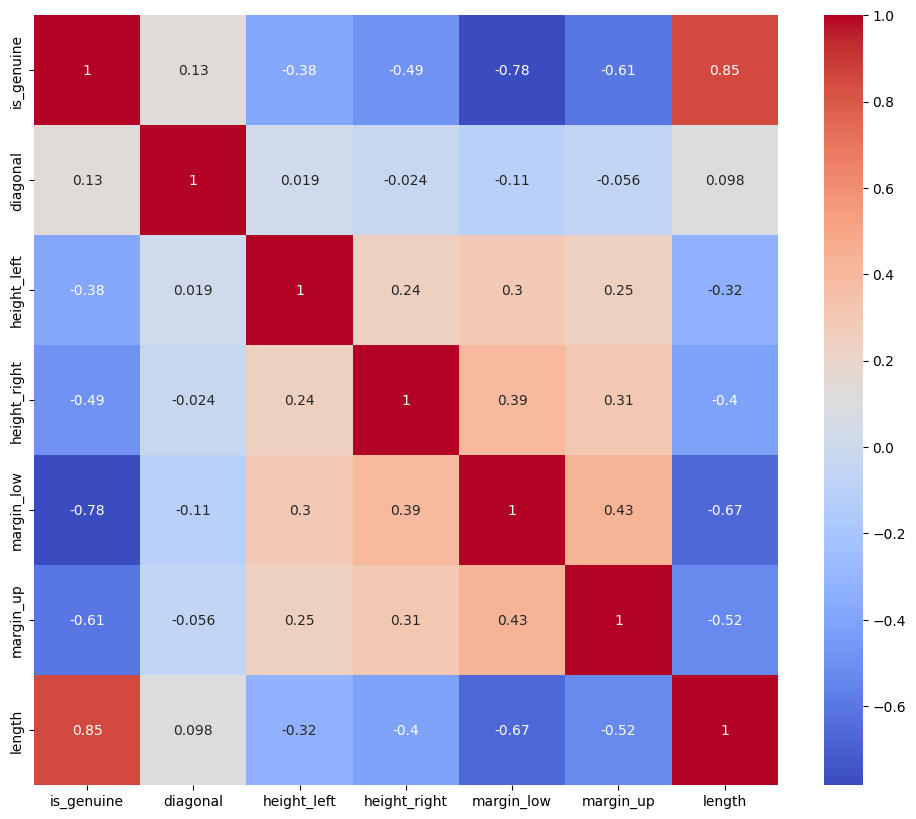

In [18]:
# Calcul de la matrice de corrélation
corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
# Affichage de la matrice de corrélation sous forme de heatmap avec seaborn
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

In [19]:
# Extraction des variables ayant une corrélation supérieure à 0.6 avec la variable d'intérêt
corr_threshold = 0.6
corr_vars = corr_matrix[abs(corr_matrix["is_genuine"]) > corr_threshold].index.tolist()

# Affichage des variables ayant une corrélation supérieure à 0.6 avec la variable d'intérêt
print("Variables ayant une corrélation supérieure à 0.6 avec la variable d'intérêt (Valeur_med_logement) :\n")
print(corr_vars)

Variables ayant une corrélation supérieure à 0.6 avec la variable d'intérêt (Valeur_med_logement) :

['is_genuine', 'margin_low', 'margin_up', 'length']


=> forte corrélation positive entre "length" & "is_genuine"

=> forte corrélation négative entre "margin_low" & "is_genuine"

=> corrélation négative entre "margin_up" & "is_genuine"

In [20]:
# Extraction des couples de variables ayant une corrélation supérieure à 0.8
corr_threshold = 0.8
corr_pairs = {}

for col in corr_matrix.columns:
    corr_pairs[col] = []
    corr_values = corr_matrix[abs(corr_matrix[col]) > corr_threshold][col].index.tolist()
    for pair in corr_values:
        if pair != col:
            corr_pairs[col].append(pair)

# Affichage des couples de variables ayant une corrélation supérieure à 0.8
print("Couples de variables ayant une corrélation supérieure à 0.8 :\n")
for col, pairs in corr_pairs.items():
    if len(pairs) > 0:
        for pair in pairs:
            print(col, "-", pair)

Couples de variables ayant une corrélation supérieure à 0.8 :

is_genuine - length
length - is_genuine


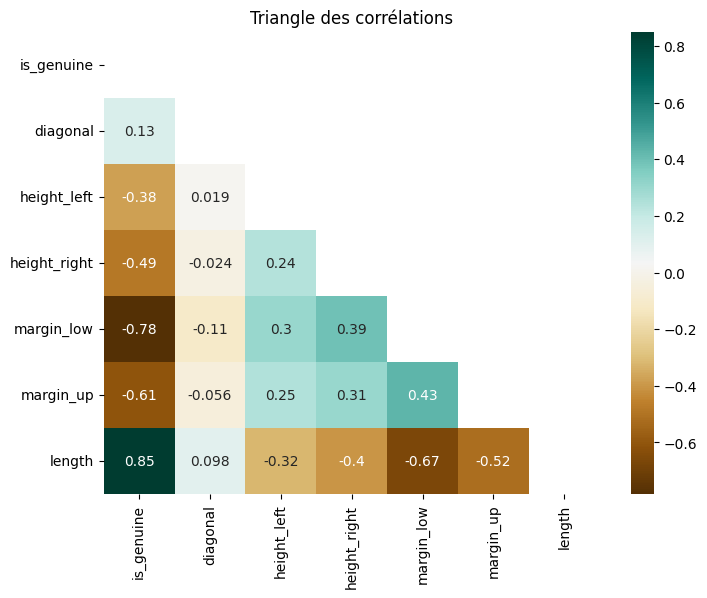

In [21]:
# Heatmap des corrélations
matrix = df.corr()
mask = np.triu(np.ones_like(matrix))
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, mask=mask, annot=True, cmap='BrBG')
plt.title('Triangle des corrélations')
plt.show()

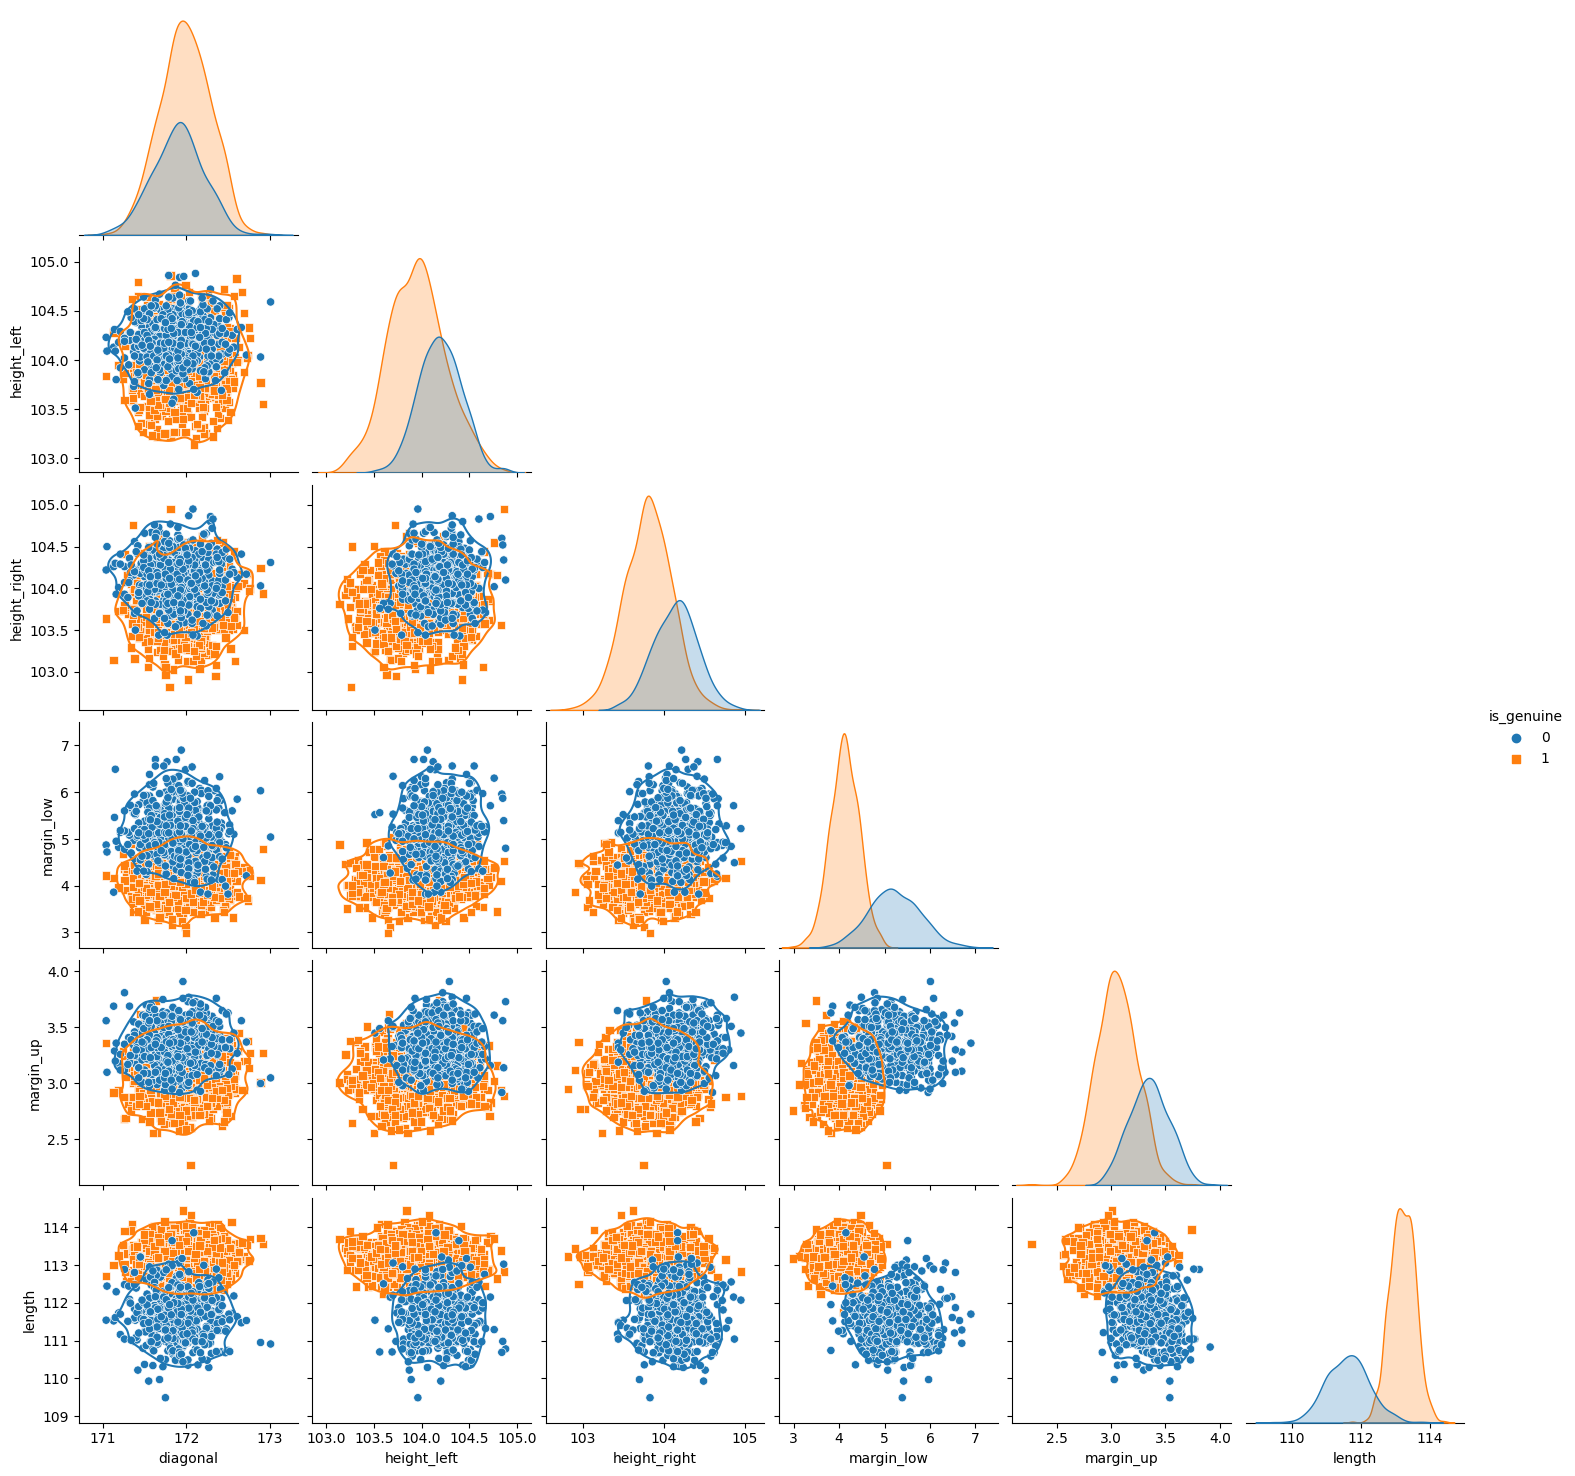

In [22]:
# Visualisation par nuage de points des différentes relations entre les variables

g = sns.pairplot(df, hue='is_genuine', markers=['o','s'], corner=True)
g.map_lower(sns.kdeplot, levels=2, color='.3')
plt.show()

=> Les 2 clusters sont nettement bien séparés quand on met en relation length & margin_low

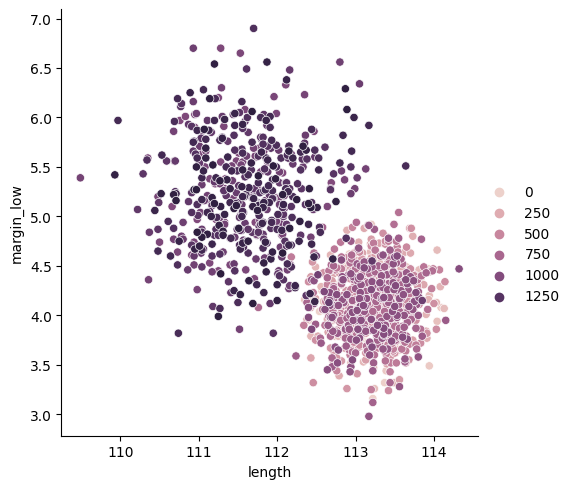

In [23]:
# Visualisation des vrais/faux billets sur 'margin_low' par rapport à 'length'

x = df['length']
y = df['margin_low']
z = df.index

sns.relplot(x = x, y = y, hue= z)
plt.show()

#### f) Valeurs manquantes

<Axes: >

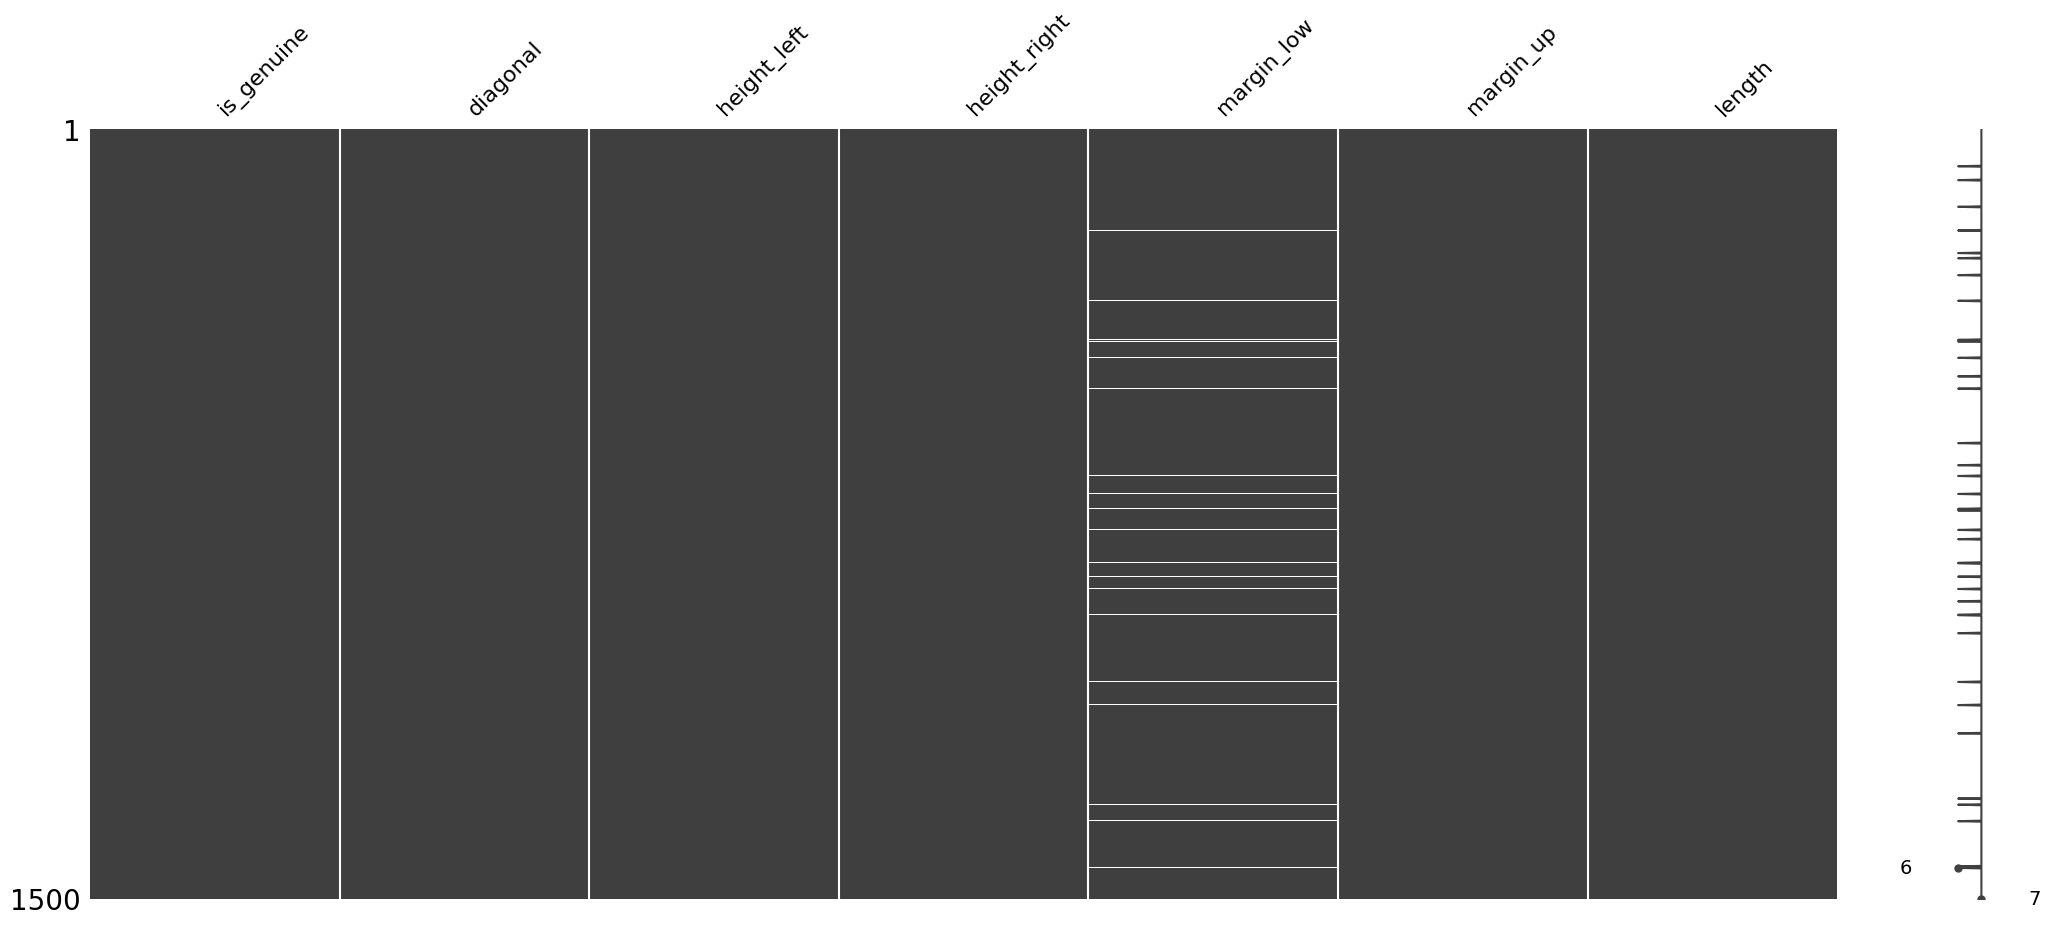

In [24]:
msno.matrix(df)

In [25]:
def exploration_data(df: pd.DataFrame):
    desc = df.columns.to_frame(name="colonne").set_index('colonne')
    desc['valeurs non nulles'] = df.notnull().sum() 
    desc['valeurs uniques'] = df.nunique()
    desc['doublons'] = df.duplicated().sum()
    desc['type de donnée'] = df.dtypes 
    desc['nombre de valeurs manquantes']=df.isna().mean()
    desc['pourcentage de valeurs nulles']=round((df.isna().sum()/df.shape[0]*100),2)
    return desc

In [26]:
exploration_data(df)

,valeurs non nulles,valeurs uniques,doublons,type de donnée,nombre de valeurs manquantes,pourcentage de valeurs nulles
colonne,,,,,,
is_genuine,1500,2,0,object,0.000000,0.00
diagonal,1500,159,0,float64,0.000000,0.00
height_left,1500,155,0,float64,0.000000,0.00
height_right,1500,170,0,float64,0.000000,0.00
margin_low,1463,285,0,float64,0.024667,2.47
margin_up,1500,123,0,float64,0.000000,0.00
length,1500,336,0,float64,0.000000,0.00


=> 37 NaN dans variable margin_low

=> La part des valeurs manquantes n'est que de 2,4%, on pourrait trés bien décider de supprimer ces lignes.

In [27]:
# Appeler la fonction pour explorer les données
nan_located = exploration_data(df)

# Filtrer le résumé pour les colonnes où il y a des valeurs manquantes
colonnes_manquantes = nan_located[nan_located['pourcentage de valeurs nulles'] > 0]
colonnes_manquantes


,valeurs non nulles,valeurs uniques,doublons,type de donnée,nombre de valeurs manquantes,pourcentage de valeurs nulles
colonne,,,,,,
margin_low,1463,285,0,float64,0.024667,2.47


In [28]:
# Nombre total d'observations
total_observations = len(df)

# Nombre total de valeurs manquantes dans 'margin_low'
total_nan = df['margin_low'].isnull().sum()

# Calculer la part de valeurs manquantes en pourcentage sur le total des observations
percentage_total_nan = (total_nan / total_observations) * 100

# Nombre de valeurs manquantes dans la catégorie True (vrai)
nan_count_true = df[df.index == True]['margin_low'].isnull().sum()

# Nombre de valeurs manquantes dans la catégorie False (faux)
nan_count_false = df[df.index == False]['margin_low'].isnull().sum()

# Nombre total d'observations par catégorie (True ou False)
total_true = len(df[df.index == True])
total_false = len(df[df.index == False])

# Calculer la part de valeurs manquantes par vrai ou faux billet (variable is_genuine)
percentage_nan_true = ((nan_count_true / total_true) * 100).round(2)
percentage_nan_false = ((nan_count_false / total_false) * 100).round(2)

# Afficher les résultats
print("Part de valeurs manquantes en % sur le total des observations :", percentage_total_nan)
print("Part de valeurs manquantes pour les vrais billets en % :", percentage_nan_true)
print("Part de valeurs manquantes pour les faux billets en % :", percentage_nan_false)


Part de valeurs manquantes en % sur le total des observations : 2.466666666666667
Part de valeurs manquantes pour les vrais billets en % : 0.0
Part de valeurs manquantes pour les faux billets en % : 0.0


In [29]:
# Afficher le détail des valeurs manquantes
for colonne in colonnes_manquantes.index:
    print(f"Colonnes: {colonne}")
    print(df[df[colonne].isna()])
    print("\n")

Colonnes: margin_low
     is_genuine  diagonal  height_left  height_right  margin_low  margin_up   
72            1    171.94       103.89        103.45         NaN       3.25  \
99            1    171.93       104.07        104.18         NaN       3.14   
151           1    172.07       103.80        104.38         NaN       3.02   
197           1    171.45       103.66        103.80         NaN       3.62   
241           1    171.83       104.14        104.06         NaN       3.02   
251           1    171.80       103.26        102.82         NaN       2.95   
284           1    171.92       103.83        103.76         NaN       3.23   
334           1    171.85       103.70        103.96         NaN       3.00   
410           1    172.56       103.72        103.51         NaN       3.12   
413           1    172.30       103.66        103.50         NaN       3.16   
445           1    172.34       104.42        103.22         NaN       3.01   
481           1    171.81      

In [30]:
df[["margin_low"]].describe()

,margin_low
count,1463.000000
mean,4.485967
std,0.663813
min,2.980000
25%,4.015000
50%,4.310000
75%,4.870000
max,6.900000


### <font color='deepskyblue'> 2. Inférer les valeurs manquantes par une régression linéaire</font>

- approche Data-centric

</font>

##### <font color="deepskyblue">2.1.1 Scinder le jeu de données en deux</font>

- df_missing contient les valeurs manquantes

- df_complete contient les données sans les NaN

In [31]:
# Séparer les lignes avec les valeurs manquantes et les lignes sans valeurs manquantes en 2 dataframes
df_missing = df[df.isnull().any(axis=1)]
df_complete = df.dropna()

# Afficher les informations sur les deux DataFrames
print("DataFrame avec des valeurs manquantes :")
print(df_missing.info())

print("\nDataFrame complet sans valeurs manquantes :")
print(df_complete.info())


DataFrame avec des valeurs manquantes :
<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     object 
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    0 non-null      float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: float64(6), object(1)
memory usage: 2.3+ KB
None

DataFrame complet sans valeurs manquantes :
<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   object 
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_

- On transforme "is_genuine" en colonne

- suppression de la colonne "is_genuine"

In [32]:
df_complete2 = df_complete.drop('is_genuine', axis=1)

In [33]:
df_complete2.head(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09


##### <font color="deepskyblue">2.1.2 Visualiser la relation linéaire</font>

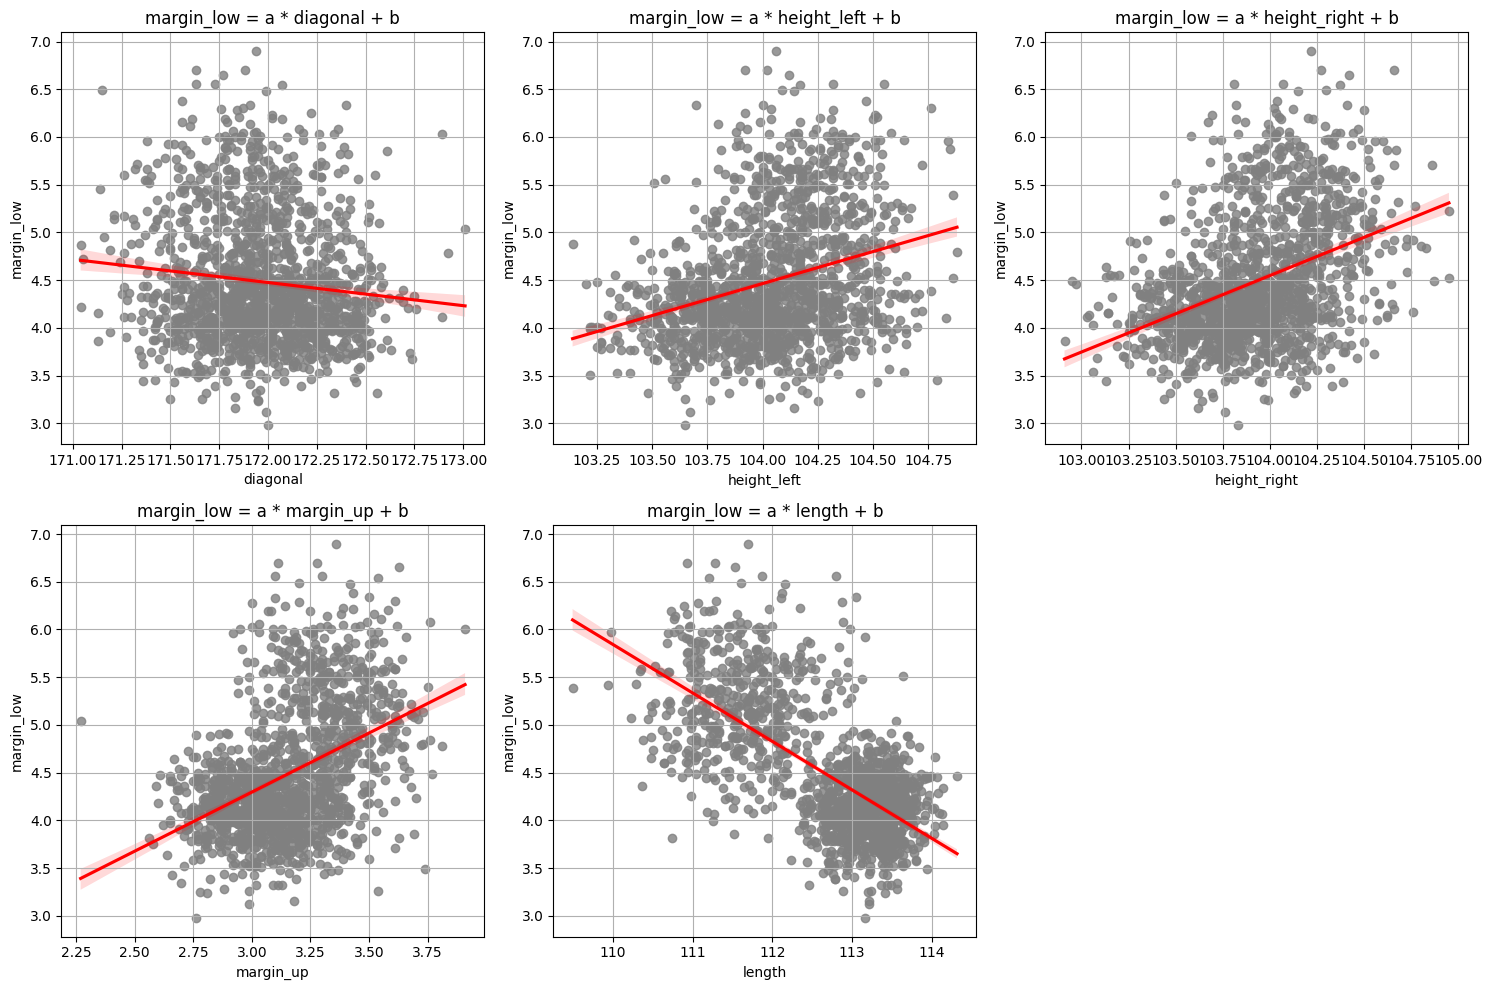

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Définir la couleur pour la ligne de régression
color_line = 'red'

sns.regplot(x=df_complete2['diagonal'], y=df_complete2['margin_low'], ax=ax[0, 0], line_kws={'color': color_line}, ci=95, scatter_kws={"color": "gray"})
ax[0, 0].set_ylabel('margin_low')
ax[0, 0].set_xlabel('diagonal')
ax[0, 0].set_title('margin_low = a * diagonal + b')
ax[0, 0].grid()

sns.regplot(x=df_complete2['height_left'], y=df_complete2['margin_low'], ax=ax[0, 1], line_kws={'color': color_line}, ci=95, scatter_kws={"color": "gray"})
ax[0, 1].set_ylabel('margin_low')
ax[0, 1].set_xlabel('height_left')
ax[0, 1].set_title('margin_low = a * height_left + b')
ax[0, 1].grid()

sns.regplot(x=df_complete2['height_right'], y=df_complete2['margin_low'], ax=ax[0, 2], line_kws={'color': color_line}, ci=95, scatter_kws={"color": "gray"})
ax[0, 2].set_ylabel('margin_low')
ax[0, 2].set_xlabel('height_right')
ax[0, 2].set_title('margin_low = a * height_right + b')
ax[0, 2].grid()

sns.regplot(x=df_complete2['margin_up'], y=df_complete2['margin_low'], ax=ax[1, 0], line_kws={'color': color_line}, ci=95, scatter_kws={"color": "gray"})
ax[1, 0].set_ylabel('margin_low')
ax[1, 0].set_xlabel('margin_up')
ax[1, 0].set_title('margin_low = a * margin_up + b')
ax[1, 0].grid()

sns.regplot(x=df_complete2['length'], y=df_complete2['margin_low'], ax=ax[1, 1], line_kws={'color': color_line}, ci=95, scatter_kws={"color": "gray"})
ax[1, 1].set_ylabel('margin_low')
ax[1, 1].set_xlabel('length')
ax[1, 1].set_title('margin_low = a * length + b')
ax[1, 1].grid()

# Masquer le sous-tracé vide
ax[1, 2].axis('off')

plt.tight_layout()
plt.show()


- Visuellement, il existe une relation linéaire négative entre margin_low et length

- il y a une corrélation négative entre margin_low et length (-0,67)

In [35]:
df_complete2.corr()

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.000000,0.018265,-0.019428,-0.111534,-0.059147,0.100758
height_left,0.018265,1.000000,0.235132,0.302643,0.243812,-0.314344
height_right,-0.019428,0.235132,1.000000,0.391085,0.306867,-0.404272
margin_low,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.059147,0.243812,0.306867,0.431606,1.000000,-0.521139
length,0.100758,-0.314344,-0.404272,-0.666753,-0.521139,1.000000


#### <font color="deepskyblue">2.1.3 Régression linéaire simple</font>

- Fonction sklearn train-test-split

- Seuil du test : 20%

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [37]:
X = df_complete2[['length']] # length est la variable explicative
y = df_complete2[['margin_low']] # variable cible à prédire

# Scission des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=808)

# Instancier le modèle
lr = LinearRegression()

# entraîner le modèle
lr.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = lr.predict(X_test)

##### <font color="deepskyblue">2.1.3.1 Evaluation du modèle</font>

In [38]:
# Evaluation sur test
print('Constante :',lr.intercept_)
print('Coef :', lr.coef_)
print('R² :',lr.score(X_test, y_test))

Constante : [60.76676949]
Coef : [[-0.49955343]]
R² : 0.4687289440929956


- Le coefficient de détermination est négatif qui suggère qu'il existe une relation négative entre la variable dépendante et la variable explicative, où une augmentation de la variable explicative est associée à une diminution de la variable dépendante : A mesure que la longueur de notre billet augmente, la marge infèrieure diminue.

- Le modèle explique environ 46.87% de la variance totale de la variable dépendante.

- Essayons de rechercher davantage de variance à expliquer dans la variable dépendante par une régression linéaire multiple. Pour ce faire, introduisons d'autres variables telles que la diagonale, les hauteurs, et les marges du billet.

In [39]:
from sklearn.metrics import mean_squared_error

# Calcul des résidus
residuals = y_test - y_pred

# Calcul de l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test, y_pred)

# Affichage de l'erreur quadratique moyenne
print("Erreur quadratique moyenne (MSE) :", mse)

Erreur quadratique moyenne (MSE) : 0.23771936990432976


- L'erreur quadratique moyenne (MSE) est une mesure de la qualité de notre modèle de régression. Elle représente la moyenne des carrés des différences entre les valeurs prédites par notre modèle et les valeurs réelles dans l'ensemble de test.

- les prédictions de notre modèle ont en moyenne une erreur quadratique de 0.2377 par rapport aux valeurs réelles dans l'ensemble de test.

##### <font color="deepskyblue">2.1.3.2 Validation croisée pour évaluer la performance de notre modèle</font>

In [40]:
from sklearn.model_selection import cross_val_score

# Instancier un nouvel objet de modèle de régression linéaire
lr_cv = LinearRegression()

# Effectuer une validation croisée avec 10 folds : c'est la division de notre ensemble d'entrainement en 10 parties égales (8% des données originales par sous-ensemble)
scores = cross_val_score(lr_cv, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Calculer la MSE moyenne à partir des scores de validation croisée
mse_mean = -scores.mean()

# Afficher la MSE moyenne
print("MSE moyenne avec validation croisée :", mse_mean)


MSE moyenne avec validation croisée : 0.24750160884651612


- Avec une MSE moyenne de 0.2475 obtenue à partir de la validation croisée à 10 folds, cela suggère que notre modèle de régression linéaire a une performance similaire à celle que nous avons obtenue précédemment avec l'approche de validation train-test.

- Robustesse : cela indique que notre modèle conserve sa capacité de prédiction même lorsqu'il est évalué sur des ensembles de données différents, ce qui est une bonne indication de sa fiabilité.

##### <font color='deepskyblue'>2.1.3.3 Sélection automatique d'un modèle avec RFE</font>

In [41]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [42]:
columns = ['diagonal','height_right','height_left','margin_up','length']

# Créer un objet de modèle de régression linéaire
model = LinearRegression()

# Créer un objet de sélection régressive en utilisant RFE (Recursive Feature Elimination)
rfe = RFE(model, n_features_to_select=1)

# Adapter le sélecteur aux données
rfe.fit(df_complete2[columns], df_complete2['margin_low'])

# Obtenir les rangs des fonctionnalités sélectionnées
feature_ranks = rfe.ranking_

# Imprimer les rangs des fonctionnalités
print("Rangs des fonctionnalités sélectionnées (plus petit = plus important):")
for feature, rank in zip(columns, feature_ranks):
    print(f"{feature}: {rank}")


Rangs des fonctionnalités sélectionnées (plus petit = plus important):
diagonal: 5
height_right: 3
height_left: 4
margin_up: 2
length: 1


=> Nous décidons d'introduire des variables supplémentaires pour réduire la variabilité résiduelle (toutes les erreurs qui auraient pues se glisser dans nos données)

=> Nous faisons le choix de tester un modèle sans la variable "diagonale" qui est définie comme la moins importante par RFE.

#### <font color="deepskyblue">2.1.4 Régression linéaire multiple sans la variable "diagonal"</font>

In [43]:
# perform linear regression to complete margin_low column
# Dividing the dataframe without NaN
X = df_complete2.drop(['margin_low','diagonal'], axis=1)# prédicteurs
y = df_complete2['margin_low'] # variable cible

In [44]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Scission des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=808)

# Ajout d'une constante aux variables explicatives de X_train et X_test
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Création du modèle de régression linéaire avec Statsmodels
model_sm = sm.OLS(y_train, X_train_const)

# Ajustement du modèle aux données d'entraînement
lr = model_sm.fit()

# utilisation de notre modèle lr pour prédire les valeurs cibles pour l'ensemble de test 'X_test_const' que nous stockons dans la variable 'y_pred'
# Prédictions sur l'ensemble de test
y_pred = lr.predict(X_test_const)


# Affichage des résultats de régression
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     255.5
Date:                Sat, 25 May 2024   Prob (F-statistic):          1.34e-157
Time:                        21:57:33   Log-Likelihood:                -809.44
No. Observations:                1170   AIC:                             1629.
Df Residuals:                    1165   BIC:                             1654.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.6204      7.928      0.835   

<font color="skyblue">

- Le modèle dans son ensemble est statistiquement significatif suggérée par la statistique de Fisher(F-statistic élevée et Prob (F-statistic) trés proche de zéro)

- Les coefficients sont tous significatifs, car les p-values associées (P>|t|) sont très faibles, proche de 0.

- R² : Notre modèle explique environ 46.7 % de la variance dans la variable "margin_low", pas de nette amélioration par rapport à la régression linéaire simple.

- Nous décidons de conserver toutes les variables prédictrices en conservant "diagonal"

</font>

#### <font color="deepskyblue">2.1.5 Régression linéaire multiple complète</font>

- Sélection d'un modèle avec l'ensemble des variables à disposition :

<font color="pink">margin_low ~ diagonal + height_right + height_left + margin_up + length, data=df_complete2</font>

In [45]:
# Dividing the dataframe without NaN
X = df_complete2.drop('margin_low', axis=1) # prédicteurs
y = df_complete2['margin_low'] # variable cible

- diviser le dataset

In [46]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Scission des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=808)

# Ajout d'une constante aux variables explicatives de X_train et X_test
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Création du modèle de régression linéaire avec Statsmodels
model_sm = sm.OLS(y_train, X_train_const)

# Ajustement du modèle aux données d'entraînement
lr = model_sm.fit()

# utilisation de notre modèle lr pour prédire les valeurs cibles pour l'ensemble de test 'X_test_const' que nous stockons dans la variable 'y_pred'
# Prédictions sur l'ensemble de test
y_pred_test = lr.predict(X_test_const)

# Prédictions sur l'ensemble d'entrainement
y_pred_train = lr.predict(X_train_const)

# résidus sur le jeu de test
resid_test = y_test - y_pred_test
print(f"dimensions des résidus sur le jeu de test: ", resid_test.shape)

# résidus sur le jeu d'entraînement
resid_train = y_train - y_pred_train
print("dimensions des résidus sur le jeu d'entrainement : ", resid_train.shape)
print("\n")
# Affichage des résultats de régression
print(lr.summary())
print(lr.summary().tables[1])
#print(lr.summary().tables[0])

dimensions des résidus sur le jeu de test:  (293,)
dimensions des résidus sur le jeu d'entrainement :  (1170,)


                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     207.7
Date:                Sat, 25 May 2024   Prob (F-statistic):          2.09e-158
Time:                        21:57:33   Log-Likelihood:                -804.71
No. Observations:                1170   AIC:                             1621.
Df Residuals:                    1164   BIC:                             1652.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------

<font color="skyblue">

- R² : Nous obtenons un meilleur score : 47,2% de la variance totale de la variance dépendante est expliquée par le modèle !

- Notre modèle est globalement significatif (F-Statistic élevé),

- toutes nos variables sont significatives < 0.05

- le test Durbin-Watson montre qu'il n'existe pas d'autocorrélation des résidus (valeur proche de 2)

**********************************

- Néanmoins, il faut vérifier :

    - la multicolinéarité (Condition Number élevé)

    - la normalité des résidus
    
    - Près de la moitié de la variabilité reste inexpliquée. Il faut essayer d'augmenter davantage le R².

</font>

## <font color="deepskyblue">3. Performance de notre modèle</font>

#### Analyse des résidus

In [47]:
from sklearn.metrics import r2_score

In [48]:
# métriques d'évaluation
# Calculer le MSE
mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
# Afficher le MSE
print("Moyenne de l'erreur quadratique (MSE) sur jeu de test :", mse_test)
print("Moyenne de l'erreur quadratique (MSE) sur jeu d'entrainement :", mse_train)
print('r² du jeu train : ', r2_train)
print('r² du jeu test : ', r2_test)
print('rmse du train : ', rmse_train)
print('rmse du test : ', rmse_test)

Moyenne de l'erreur quadratique (MSE) sur jeu de test : 0.22542386521234578
Moyenne de l'erreur quadratique (MSE) sur jeu d'entrainement : 0.2317023719659529
r² du jeu train :  0.4715592178836593
r² du jeu test :  0.4962077556145337
rmse du train :  0.4813547257127044
rmse du test :  0.47478823196488956


- Construction du tableau de résultats

In [49]:
df_metrics = pd.DataFrame({
    'Métrique': ['R2', 'MSE', 'RMSE'],
    'Train': [r2_train, mse_train, rmse_train],
    'Test': [r2_test, mse_test, rmse_test]
})

print(df_metrics)

  Métrique     Train      Test
0       R2  0.471559  0.496208
1      MSE  0.231702  0.225424
2     RMSE  0.481355  0.474788


- La moyenne de l'erreur quadratique (MSE) est d'environ 0.2254. Cela indique en moyenne à quel point les prédictions de notre modèle sont éloignées des valeurs réelles, avec une erreur quadratique moyenne de 0.2254. 

- Plus le MSE est proche de zéro, meilleure est la performance du modèle.

- Amélioration des performances en termes de précision de prédiction par rapport à nos modèles précédents (0.2254 vs 0.2475)

- le modèle performe légèrement mieux sur les données de test que sur les données d'entraînement, ce qui est généralement une bonne indication.

- la différence entre les deux MSE n'est pas significative, ce qui indique que le modèle généralise bien et ne semble pas souffrir de surajustement (overfitting) ou de sous-ajustement (underfitting) majeur.

=> ces métriques suggèrent que notre modèle a une performance similaire sur les ensembles d'entraînement et de test, avec une capacité raisonnable à expliquer la variance dans les données et à faire des prédictions précises.

- Visualier les valeurs observées en fonction des valeurs prédites sur les données d'entrainement

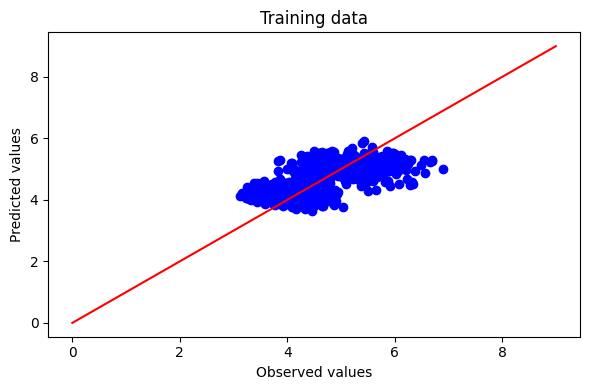

In [50]:
plt.figure(figsize=(6, 4))
plt.scatter(x=y_train, y=y_pred_train, color='blue')
plt.ylabel('Predicted values')
plt.xlabel('Observed values')
plt.title('Training data')
plt.plot(np.arange(0,10,3), np.arange(0,10,3), color='red')

plt.tight_layout()
plt.show()


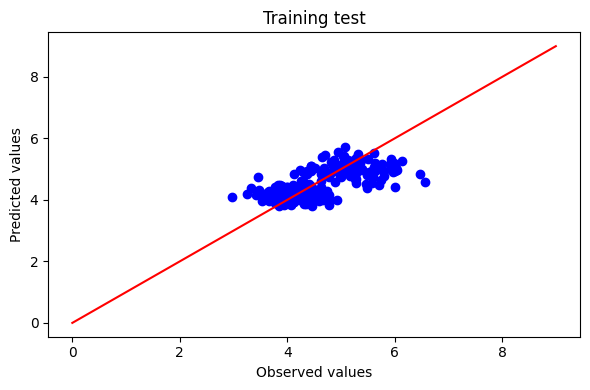

In [51]:
plt.figure(figsize=(6, 4))
plt.scatter(x=y_test, y=y_pred_test, color='blue')
plt.ylabel('Predicted values')
plt.xlabel('Observed values')
plt.title('Training test')
plt.plot(np.arange(0,10,3), np.arange(0,10,3), color='red')

plt.tight_layout()
plt.show()


### <font color='deepskyblue'>3.1 Vérification des hypothèses

#### 3.1.1 Vérification de l'homoscédasticité

</font>

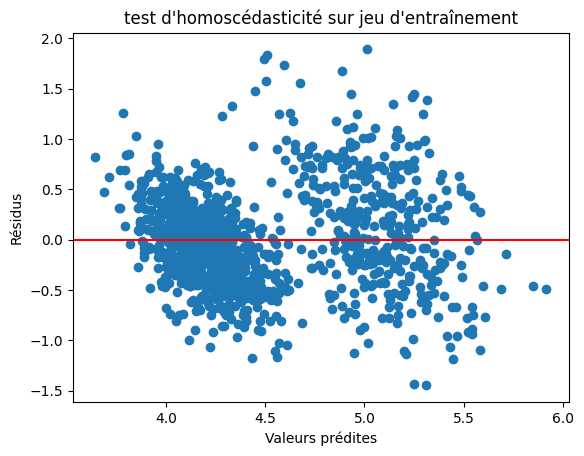

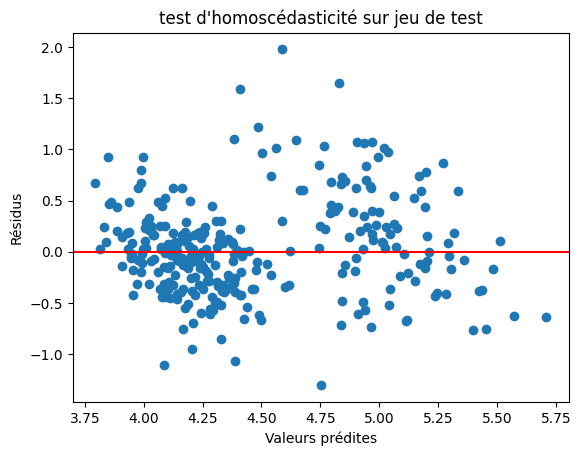

In [52]:
# Création d'un scatter plot pour visualiser la linéarité des résidus sur les données d'entraînement
plt.scatter(y_pred_train, resid_train)
plt.axhline(y=0, color='r', linestyle='-')  
plt.title('test d\'homoscédasticité sur jeu d\'entraînement')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.show()

# Création d'un scatter plot pour visualiser la linéarité des résidus sur les données de test
plt.scatter(y_pred_test, resid_test)
plt.axhline(y=0, color='r', linestyle='-') 
plt.title('test d\'homoscédasticité sur jeu de test')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.show()


- Test de Breusch-Pagan

In [53]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Effectuer le test de Breusch-Pagan
bp_test = het_breuschpagan(resid_train, X_train_const)
p_value = bp_test[1]

# Interprétation du test de Breusch-Pagan
alpha = 0.05
if p_value > alpha:
    print("Pas de preuve significative d'homoscédasticité (p-value > 0.05 : ", p_value, ")")
else:
    print("Preuve significative d'homoscédasticité (p-value < 0.05 : ", p_value, ")")


Preuve significative d'homoscédasticité (p-value < 0.05 :  2.3716448342116843e-14 )


- il existe une hétéroscédasticité dans les résidus du modèle, ce qui indique que la variance des résidus n'est pas constante et dépend des variables explicatives. 

- Distribution des résidus du jeu de données d'entrainement et de test

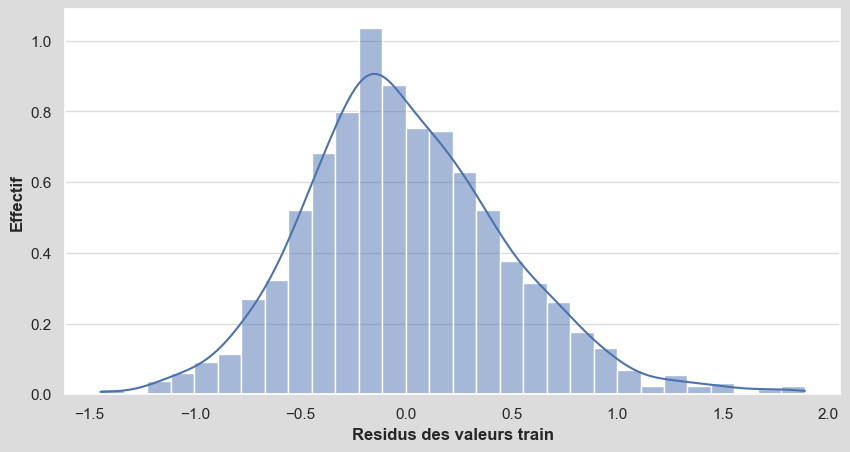

In [54]:
sns.set(rc={'figure.figsize':(10, 5), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph3b = sns.histplot(resid_train, kde=True, stat='density')
plt.xlabel('Residus des valeurs train', fontweight='bold', fontsize='12')
plt.ylabel('Effectif', fontweight='bold', fontsize='12')
plt.grid(axis='y', color='gainsboro')
plt.savefig("distribution_residus.png", bbox_inches='tight')

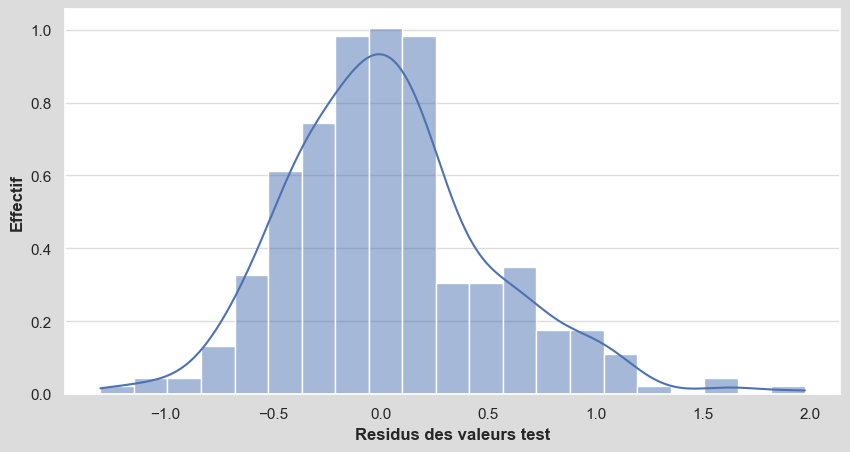

In [55]:
sns.set(rc={'figure.figsize':(10, 5), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
graph3b = sns.histplot(resid_test, kde=True, stat='density')
plt.xlabel('Residus des valeurs test', fontweight='bold', fontsize='12')
plt.ylabel('Effectif', fontweight='bold', fontsize='12')
plt.grid(axis='y', color='gainsboro')
plt.savefig("distribution_residus.png", bbox_inches='tight')

#### <font color="deepskyblue">3.1.2 Vérification de la normalité</font>

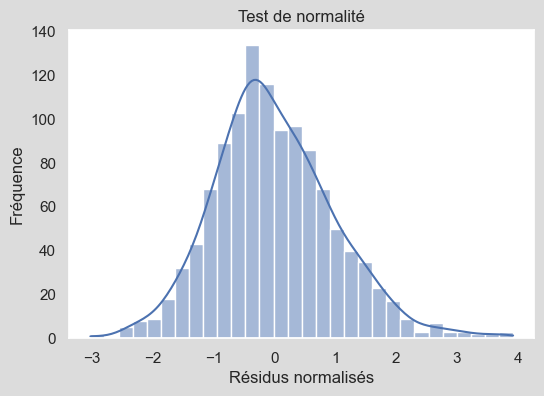

In [56]:
# test de normalité
resid_norm = lr.get_influence().resid_studentized_internal
plt.figure(figsize=(6, 4))
sns.histplot(resid_norm, kde=True)
plt.title('Test de normalité')
plt.xlabel('Résidus normalisés')
plt.ylabel('Fréquence')
plt.show()


- la distribution est proche d'une forme en cloche symétrique, cela suggère que l'hypothèse de normalité des résidus est raisonnablement respectée. 

In [57]:
from scipy import stats
# Test de normalité de Shapiro-Wilk
shapiro_test = stats.shapiro(resid_train)
p_value = shapiro_test[1]

# Interprétation du test de Shapiro-Wilk
alpha = 0.05
if p_value > alpha:
    print("test Shapiro-Wilk : La distribution des résidus semble suivre une distribution normale (p-value =", p_value, ")")
else:
    print("test Shapiro-Wilk : La distribution des résidus ne semble pas suivre une distribution normale (p-value =", p_value, ")")
    

test Shapiro-Wilk : La distribution des résidus ne semble pas suivre une distribution normale (p-value = 7.18940018629155e-09 )


In [58]:
from scipy.stats import kstest

# Test de normalité des résidus avec Kolmogorov-Smirnov
stat, p_value = kstest(resid_train, 'norm')
print("Statistique de test de normalité des résidus (Kolmogorov-Smirnov) :", stat)
print("P-value :", p_value)
if p_value < 0.05:
    print("Les résidus d'entrainement ne suivent pas une distribution normale.")
else:
    print("Les résidus d'entrainement suivent une distribution normale.")


print("\n")

# Test de normalité des résidus avec Kolmogorov-Smirnov
stat, p_value = kstest(resid_test, 'norm')
print("Statistique de test de normalité des résidus (Kolmogorov-Smirnov) :", stat)
print("P-value :", p_value)
if p_value < 0.05:
    print("Les résidus des données test ne suivent pas une distribution normale.")
else:
    print("Les résidus des données test suivent une distribution normale.")

Statistique de test de normalité des résidus (Kolmogorov-Smirnov) : 0.19132686171258778
P-value : 5.530402021193502e-38
Les résidus d'entrainement ne suivent pas une distribution normale.


Statistique de test de normalité des résidus (Kolmogorov-Smirnov) : 0.21303085168643338
P-value : 3.7887680498832515e-12
Les résidus des données test ne suivent pas une distribution normale.


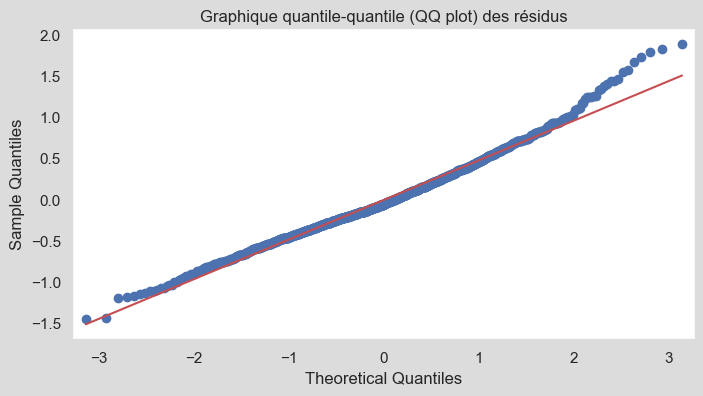

In [59]:
# Création du QQ plot
fig, ax = plt.subplots(figsize=(8, 4))
sm.qqplot(resid_train, line='s', ax=ax)
ax.set_title('Graphique quantile-quantile (QQ plot) des résidus')
plt.show()


#### <font color="deepskyblue">3.1.3 Vérification de la multicolinéarité avec VIF - Variance Inflation Factor</font>

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_train_const.values, i) for i in range(X_train_const.shape[1])]
vif["features"] = X_train_const.columns
print(vif)


      VIF Factor      features
0  601316.466025         const
1       1.011842      diagonal
2       1.143630   height_left
3       1.250358  height_right
4       1.406416     margin_up
5       1.603271        length


- Tous les facteurs VIF sont bien inférieurs à 5, ce qui suggère qu'il n'y a pas de forte corrélation entre les variables explicatives. 

En conclusion, les facteurs VIF semblent indiquer qu'il n'y a pas de multicollinéarité significative dans nos données.

#### <font color="deepskyblue">3.1.4 Vérification de l'autocorrélation</font>

In [61]:
from statsmodels.stats.stattools import durbin_watson

# Calculer la statistique de Durbin-Watson
durbin_watson_stat = durbin_watson(resid_train)
durbin_watson_stat_test = durbin_watson(resid_test)
# Afficher la statistique de Durbin-Watson
print("Statistique de Durbin-Watson pour l'autocorrélation des résidus du jeu d'entrainement :", durbin_watson_stat)
print("Statistique de Durbin-Watson pour l'autocorrélation des résidus du jeu de test :", durbin_watson_stat_test)

Statistique de Durbin-Watson pour l'autocorrélation des résidus du jeu d'entrainement : 2.005287330637983
Statistique de Durbin-Watson pour l'autocorrélation des résidus du jeu de test : 1.9730080199656312


- Une valeur proche de 2 indique généralement qu'il n'y a pas d'autocorrélation significative.

#### <font color="deepskyblue">3.1.5 Moyenne des termes d'erreur</font>

In [62]:
mean_resid_train = resid_train.mean()
mean_resid_test = resid_test.mean()

print("Moyenne des résidus sur le jeu d'entraînement :", mean_resid_train)
print("Moyenne des résidus sur le jeu de test :", mean_resid_test)


Moyenne des résidus sur le jeu d'entraînement : -2.6144328867070355e-15
Moyenne des résidus sur le jeu de test : 0.03385696783869508


=> Les moyennes des résidus obtenues sont proches de zéro, ce qui est une bonne indication. Une moyenne des résidus proche de zéro suggère que les erreurs de prédiction en moyenne sont équilibrées autour de zéro, ce qui est un comportement attendu pour un modèle de régression bien ajusté.

##### <font color="deepskyblue">3.1.5.1 Visualisation de l'erreur</font>

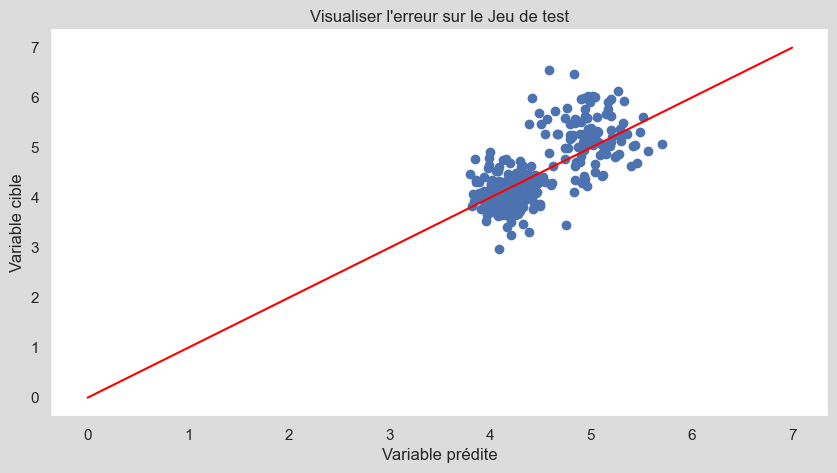

In [63]:
plt.scatter(y_pred_test, y_test)
plt.plot(np.arange(0, 8), np.arange(0, 8), color='red')
plt.ylabel('Variable cible')
plt.xlabel('Variable prédite')
plt.title('Visualiser l\'erreur sur le Jeu de test')
plt.show()

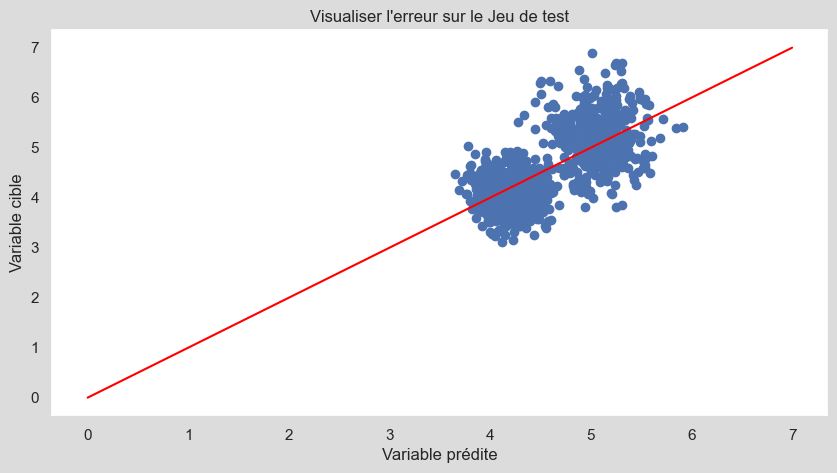

In [64]:
plt.scatter(y_pred_train, y_train)
plt.plot(np.arange(0, 8), np.arange(0, 8), color='red')
plt.ylabel('Variable cible')
plt.xlabel('Variable prédite')
plt.title('Visualiser l\'erreur sur le Jeu de test')
plt.show()

#### <font color="deepskyblue">3.1.6 Distribution des résidus</font>

Stockons nos résidus train et test dans une copie de notre dataframe df_complete

In [65]:
# Créer une copie du DataFrame complet
df_complete_reg = df_complete.copy()

# Ajouter une colonne pour les résidus sur le jeu d'entraînement
df_complete_reg['resid_train'] = resid_train

# Ajouter une colonne pour les résidus sur le jeu de test
df_complete_reg['resid_test'] = resid_test

# Afficher les premières lignes du DataFrame avec les résidus
print("Premières lignes du DataFrame complet avec les résidus :\n", df_complete_reg.head())


Premières lignes du DataFrame complet avec les résidus :
   is_genuine  diagonal  height_left  height_right  margin_low  margin_up   
0          1    171.81       104.86        104.95        4.52       2.89  \
1          1    171.46       103.36        103.66        3.77       2.99   
2          1    172.69       104.48        103.50        4.40       2.94   
3          1    171.36       103.91        103.94        3.62       3.01   
4          1    171.73       104.28        103.46        4.04       3.48   

   length  resid_train  resid_test  
0  112.83    -0.250403         NaN  
1  113.09    -0.398841         NaN  
2  113.16     0.320308         NaN  
3  113.51    -0.560344         NaN  
4  112.54    -0.529106         NaN  


In [66]:
# Transformer les valeurs True en 1 et False en 0 dans la colonne 'is_genuine'
df_complete_reg['is_genuine'] = df_complete_reg['is_genuine'].replace({1: True, 0: False})

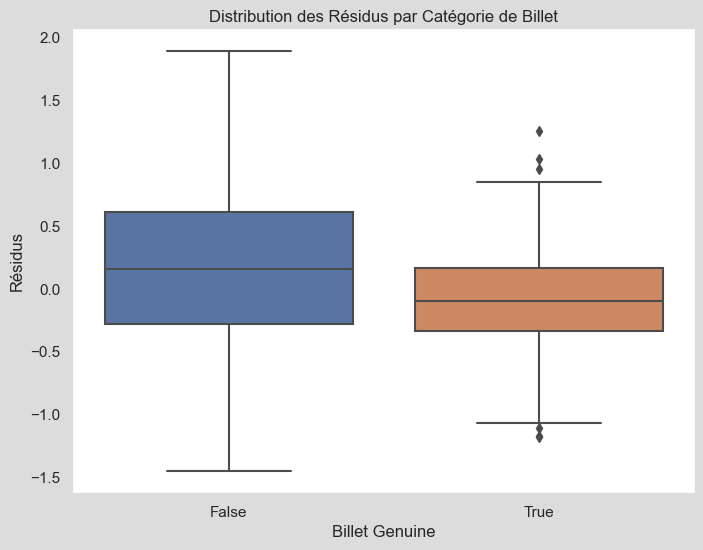

In [67]:
# Créer un boxplot pour représenter la distribution des résidus par catégorie de billet
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_genuine', y='resid_train', data=df_complete_reg)
plt.xlabel('Billet Genuine')
plt.ylabel('Résidus')
plt.title('Distribution des Résidus par Catégorie de Billet')
plt.xticks(ticks=[0, 1], labels=['False', 'True'])  # Renommer les étiquettes
plt.show()


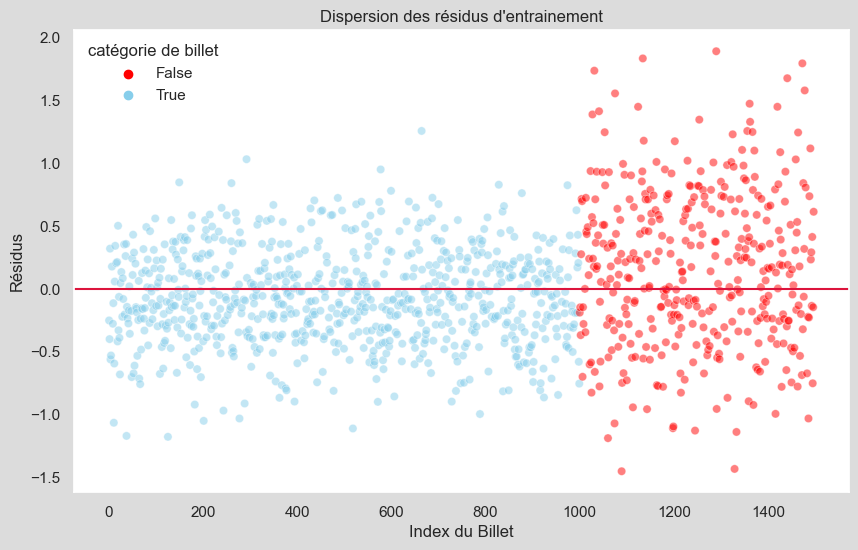

In [68]:
# scatterplot des résidus
sns.set(rc={'figure.figsize':(10,6),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
ax = sns.scatterplot(x=df_complete_reg.index, y=df_complete_reg['resid_train'],
                     data=df_complete_reg, hue='is_genuine', palette=['red', 'skyblue'], alpha=0.5)

ax.set(xlabel='Index du Billet', ylabel='Résidus')
plt.legend(title='catégorie de billet', frameon=False)
plt.axhline(0, color='crimson')
plt.title('Dispersion des résidus d\'entrainement')
plt.savefig('scatter_residus_train.png')
plt.show()


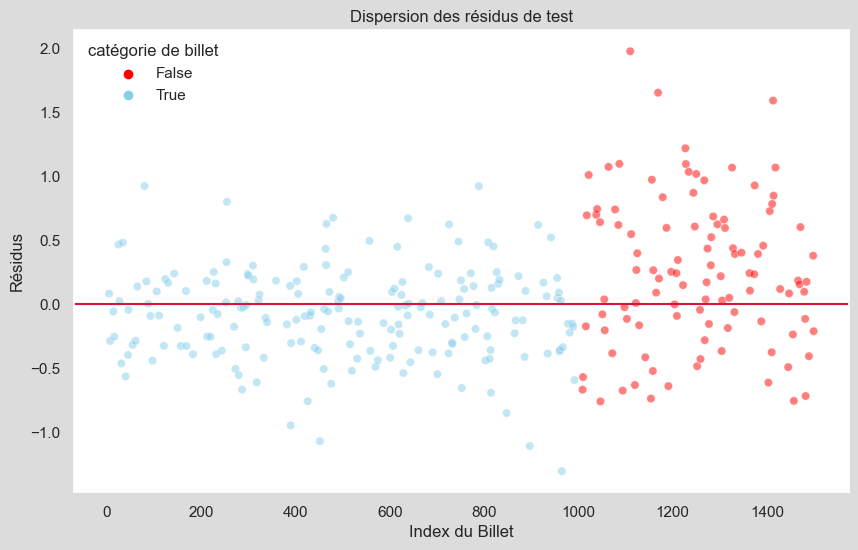

In [69]:
# scatterplot des résidus
sns.set(rc={'figure.figsize':(10,6),'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
ax = sns.scatterplot(x=df_complete_reg.index, y=df_complete_reg['resid_test'],
                     data=df_complete_reg, hue='is_genuine', palette=['red', 'skyblue'], alpha=0.5)

ax.set(xlabel='Index du Billet', ylabel='Résidus')
plt.legend(title='catégorie de billet', frameon=False)
plt.axhline(0, color='crimson')
plt.title('Dispersion des résidus de test')
plt.savefig('scatter_residus_test.png')
plt.show()


=> On constate le même phénomène que sur nos résidus du jeu de test : les billets faux sont plus dispersés,s'éloignant de 0.

*************************************************************************************************************************

## <font color="deepskyblue">5. Complétude de notre dataframe avec les valeurs prédites par la régression linéaire multiple</font>

In [70]:
# ajouter la constante à notre df (first column)
df = sm.add_constant(df, prepend=True, has_constant='skip')

# remplacer les NaN avec valeurs prédites par la régression linéaire
df.loc[(df['margin_low'].isna() == True), 'margin_low'] = lr.predict(df[['const','diagonal',
                                                                        'height_left',
                                                                        'height_right',
                                                                        'margin_up', 'length']])
# supprimer la colonne "const"
df_final = df.drop('const', axis=1)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   object 
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), object(1)
memory usage: 82.2+ KB


<Axes: >

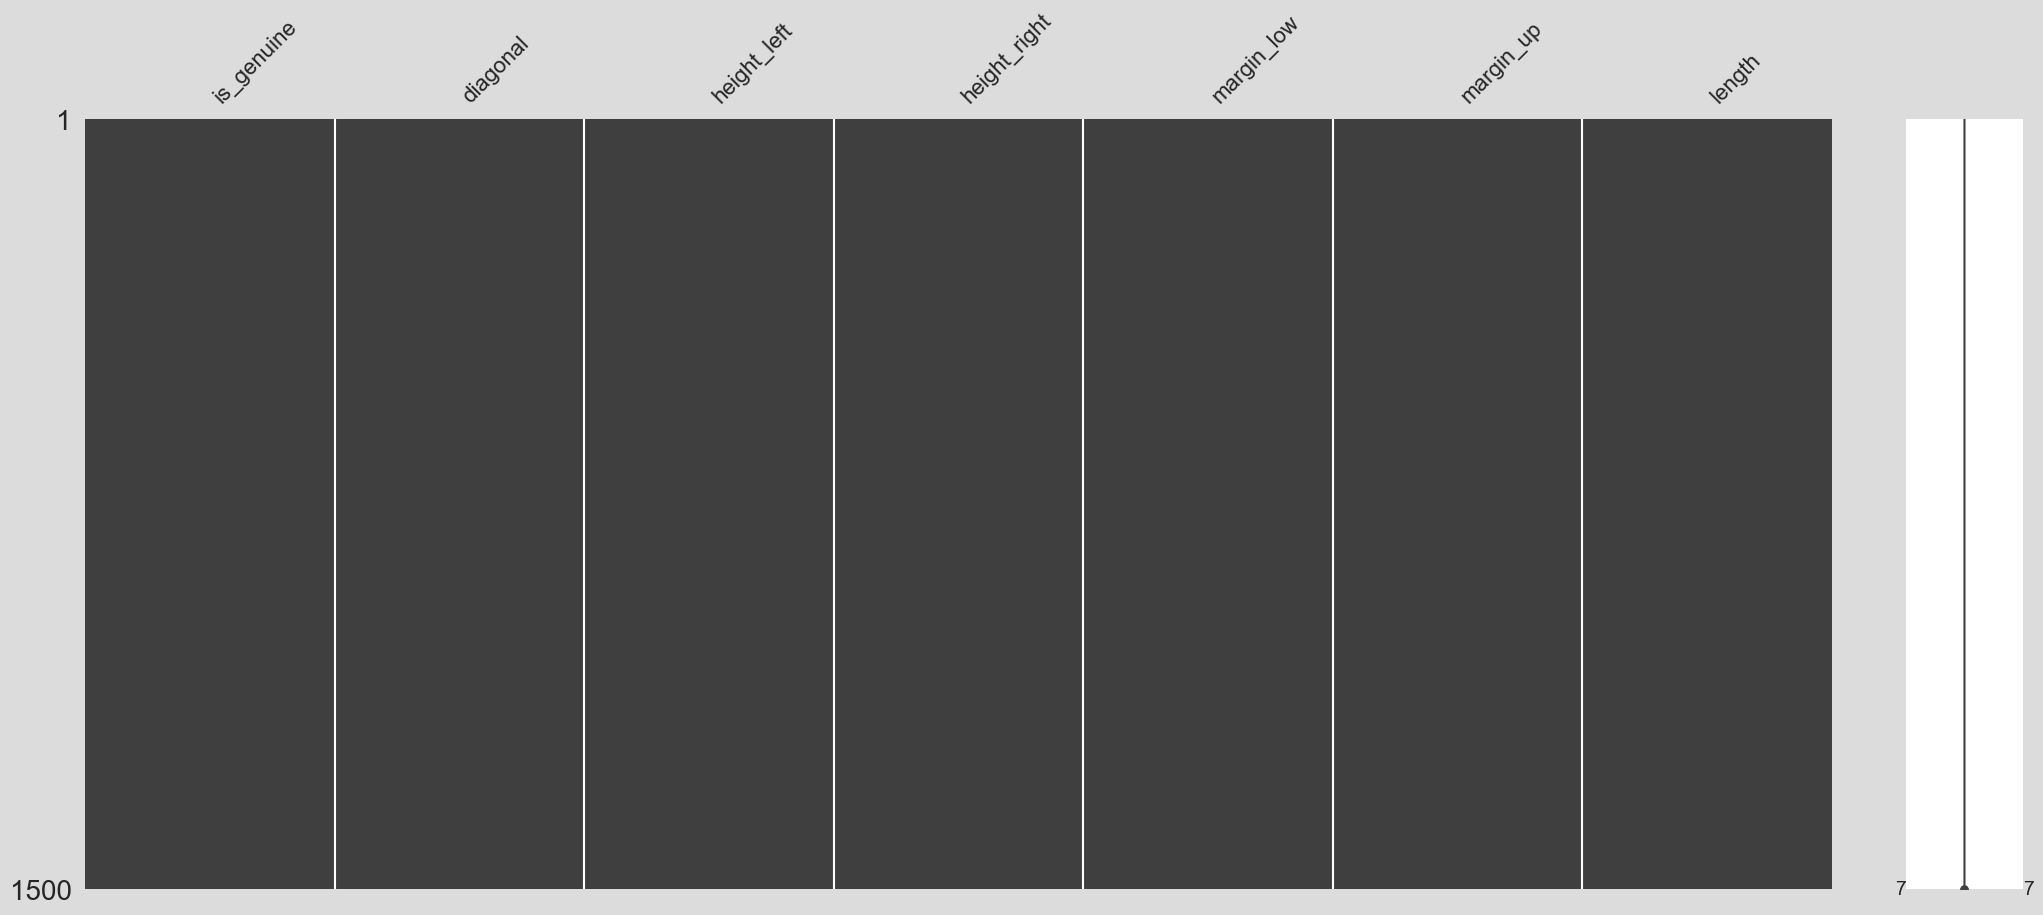

In [71]:
# check NaN
msno.matrix(df_final)

In [72]:
exploration_data(df_final)

,valeurs non nulles,valeurs uniques,doublons,type de donnée,nombre de valeurs manquantes,pourcentage de valeurs nulles
colonne,,,,,,
is_genuine,1500,2,0,object,0.0,0.0
diagonal,1500,159,0,float64,0.0,0.0
height_left,1500,155,0,float64,0.0,0.0
height_right,1500,170,0,float64,0.0,0.0
margin_low,1500,322,0,float64,0.0,0.0
margin_up,1500,123,0,float64,0.0,0.0
length,1500,336,0,float64,0.0,0.0


=> Notre dataframe ne comporte plus aucune valeur manquante.

In [73]:
df_final = df_final.set_index("is_genuine")
df_final.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483395,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659494,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


#### <font color="deepskyblue">Outliers

=> Les valeurs maximales sont trés proches de la moyenne, alors nous partirons de l'hypothèse que les outliers sont ici des valeurs atypiques mais non abérrentes et influentes !

</font>

In [74]:
df_final = df_final.reset_index()

In [75]:
df_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [76]:
df_final.to_csv('df_final_index.csv', index=True)

********************************************* fin 1ER NOTEBOOK *******************************************

*********************************************************************************************